# Getting Started with cuML's accelerator mode (cuml.accel)


cuML is a Python GPU library for accelerating machine learning models using a scikit-learn-like API.

cuML now has an accelerator mode (cuml.accel) which allows you to bring accelerated computing to existing workflows with zero code changes required. In addition to scikit-learn, cuml.accel also provides acceleration to algorithms found in umap-learn (UMAP) and hdbscan (HDBSCAN).

This notebook is a brief introduction to cuml.accel.

# ⚠️ Verify your setup

First, we'll verfiy that we are running on an NVIDIA GPU:

In [1]:
!nvidia-smi  # this should display information about available GPUs

Wed Apr 16 01:38:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   65C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

With classical machine learning, there is a wide range of interesting problems we can explore. In this tutorial we'll examine 3 of the more popular use cases: classification, clustering, and dimensionality reduction.

# Classification

Let's load a dataset and see how we can use scikit-learn to classify that data.  For this example we'll use the Coverage Type dataset, which contains a number of features that can be used to predict forest cover type, such as elevation, aspect, slope, and soil-type.

More information on this dataset can be found at https://archive.ics.uci.edu/dataset/31/covertype.

In [7]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
%load_ext cuml.accel

[2025-04-16 01:40:44.076] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-04-16 01:41:19.731] [CUML] [info] cuML: Installed accelerator for umap.
[2025-04-16 01:41:19.825] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-04-16 01:41:19.825] [CUML] [info] cuML: Successfully initialized accelerator.


In [2]:
import pandas as pd

In [36]:
data = pd.read_csv('/content/2025-04-16T01-25_export.csv')
nexa = pd.read_csv('/content/nexa_results.csv')

In [4]:
data.columns

NameError: name 'data' is not defined

In [37]:
nexa.columns = ["provider","provider_url","model","model_url", "quantization", "quantization_url","IFEVal", "RAM(GB)","FileSize(GB)","TotalResponseTime(s)","OutputSpeed(Tok/s)","PrefillSpeed(Tok/s)","PowerConsumption(t/kW)"]

In [38]:
nexa.to_csv('nexa_data.csv')

<ipython-input-206-35b40cb5eb37>:29: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



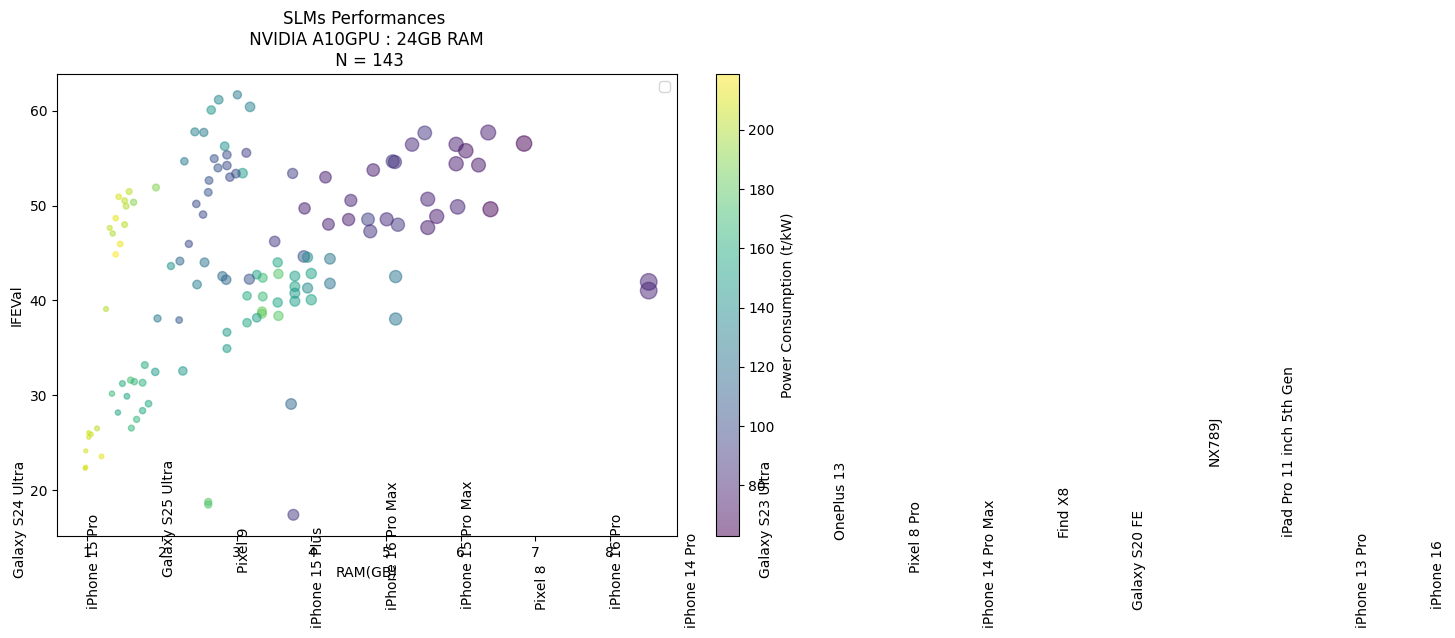

In [206]:
# prompt: Make a bubble plot with Perf vertical (IFEVAL, TotalSpeed Horizontal, and PowerConsumption as bubble size)

import matplotlib.pyplot as plt

# Assuming 'nexa' DataFrame is already loaded as in the previous code
filtered_nexa = nexa[nexa["FileSize(GB)"]<7.5]
filtered_nexa = filtered_nexa[filtered_nexa["RAM(GB)"]<10]

# Create the bubble plot
plt.figure(figsize=(10, 6))
plt.scatter(filtered_nexa['RAM(GB)'], filtered_nexa['IFEVal'], s=filtered_nexa["FileSize(GB)"] * 20, c=filtered_nexa['PowerConsumption(t/kW)'] * 0.0001, alpha=0.5)  # Adjust bubble size scaling as needed

# Add labels and title
plt.xlabel('RAM(GB)')
plt.ylabel('IFEVal')

top_devices = data['Device'].value_counts().head(20).index

top_data = data[data['Device'].isin(top_devices)][['Device', 'Total Memory (GB)']]


plt.title(f'SLMs Performances \n NVIDIA A10GPU : 24GB RAM \n N = {len(filtered_nexa)}')

for i, device in enumerate(top_data['Device'].unique()):
    median_ram = top_data[top_data['Device'] == device]['Total Memory (GB)'].max()
    plt.text(i, median_ram, device, ha='left', va='bottom', rotation=90)


# Add a colorbar to indicate bubble size
plt.colorbar(label='Power Consumption (t/kW)')
plt.legend()

plt.show()


In [10]:
import plotly.express as px

# Assuming 'nexa' and 'data' DataFrames are already loaded

filtered_nexa = nexa[nexa["FileSize(GB)"] < 7.5]
filtered_nexa = filtered_nexa[nexa["RAM(GB)"] < 10]

# Get top 20 devices from 'data' DataFrame
top_devices = data['Device'].value_counts().head(20).index
top_data = data[data['Device'].isin(top_devices)][['Device', 'Total Memory (GB)']]

# Create the Plotly scatter plot
fig = px.scatter(filtered_nexa,
                 x="RAM(GB)",
                 y="IFEVal",
                 size="FileSize(GB)",
                 color="PowerConsumption(t/kW)",
                 hover_name="model",
                 title=f'SLMs Performances<br>NVIDIA A10GPU: 24GB RAM<br>N = {len(filtered_nexa)}',
                 labels={"RAM(GB)": "RAM (GB)", "IFEVal": "IFEVal", "FileSize(GB)": "File Size (GB)", "PowerConsumption(t/kW)": "Power Consumption (t/kW)"},
                 )

fig.update_layout(title_x=0.5)

# Update layout to ensure y-axis range is available
fig.update_layout(yaxis_range=[0, max(filtered_nexa['IFEVal']) + 1])

fig.show()

# Add device names as text annotations AFTER fig.show() and update_layout
for i, device in enumerate(top_data['Device'].unique()):
    median_ram = top_data[top_data['Device'] == device]['Total Memory (GB)'].median()
    fig.add_annotation(x=median_ram, y=fig.layout.yaxis.range[0],  # Place at bottom of y-axis
                      text=device, showarrow=False,
                      textangle=-45,  # Rotate text vertically
                      xanchor="center", yanchor="top")  # Text alignment

<ipython-input-10-bf2f483df22a>:6: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [34]:
# !pip install plotly # Make sure plotly is installed
import plotly.express as px
import pandas as pd # Assuming pandas is used for DataFrames




# Filter the nexa data as before
filtered_nexa = nexa[nexa["FileSize(GB)"] < 7.5].copy() # Use .copy() to avoid SettingWithCopyWarning
filtered_nexa = filtered_nexa[filtered_nexa["RAM(GB)"] < 10]

# Get top 20 devices and their median RAM from 'data' DataFrame
top_devices_counts = data['Device'].value_counts().head(20)
top_devices = top_devices_counts.index
# Calculate median RAM only for the top devices needed
top_data_ram = data[data['Device'].isin(top_devices)][['Device', 'Total Memory (GB)']]
median_ram_map = top_data_ram.groupby('Device')['Total Memory (GB)'].median()

# Create the Plotly scatter plot
fig = px.scatter(filtered_nexa,
                 y="RAM(GB)",
                 x="IFEVal",
                 size="FileSize(GB)",
                 color="PowerConsumption(t/kW)",
                 hover_name="model",
                 title=f'SLMs Performances<br>NVIDIA A10GPU: 24GB RAM<br>N = {len(filtered_nexa)}',
                 labels={"RAM(GB)": "RAM (GB)", "IFEVal": "IFEVal", "FileSize(GB)": "File Size (GB)", "PowerConsumption(t/kW)": "Power Consumption (t/kW)"},
                 )

# Update layout: center title, set y-axis range, add bottom margin for annotations
fig.update_layout(
    title_x=0.5,
    yaxis_range=[0, filtered_nexa['RAM(GB)'].max() * 1.3], # Set range slightly above max value
    margin=dict(l=300) # Increase bottom margin to make space for text
)

data_above_seven = data[data["PP Avg (t/s)"] > 7]
# Assuming 'data' DataFrame is already loaded as in the previous code
list_devices = ()

# Group data by 'model_size' and find the maximum 'Total Memory (GB)' for each group
max_memory_by_size = data_above_seven.groupby('model_size')['Total Memory (GB)'].min()

list_devices_df = pd.DataFrame(columns=["Model Size", "Device", "PhoneRAM"])
# Iterate through unique 'model_size' values
for model_size, max_memory in max_memory_by_size.items():
    # Find the device(s) with the maximum memory for the current model size
    devices_with_max_memory = data_above_seven[(data_above_seven['model_size'] == model_size) & (data_above_seven['Total Memory (GB)'] == max_memory)]['Device'].unique()

    txt_annotation = ', '.join(devices_with_max_memory)
    fig.add_annotation(
          y=model_size,                   # X position based on median RAM
          x=0,                            # Y position at the bottom of the plot area
          xref="paper",                   # Use 'paper' reference for y (0=bottom, 1=top)
          xshift=-150,                     # Shift slightly below the axis line
          text=txt_annotation,                    # The device name text
          showarrow=False,
          textangle=0,                  # Rotate text for better readability (-45 to -90 are common)
          xanchor="left",               # Anchor the center of the text horizontally
          yanchor="middle"                   # Anchor the TOP of the text at the specified y (so text goes down)
      )

fig.write_html("annotated_scatter_plot.html")

# fig.show()

In [18]:
# !pip install plotly # Make sure plotly is installed
import plotly.express as px
import pandas as pd # Assuming pandas is used for DataFrames
import numpy as np  # For simulation


# Filter the nexa data as before
filtered_nexa = nexa[nexa["FileSize(GB)"] < 7.5].copy()
filtered_nexa = filtered_nexa[filtered_nexa["RAM(GB)"] < 10]

# Create the Plotly scatter plot
fig = px.scatter(filtered_nexa,
                 x="RAM(GB)",
                 y="IFEVal",
                 size="FileSize(GB)",
                 color="PowerConsumption(t/kW)",
                 hover_name="model",
                 title=f'SLMs Performances<br>NVIDIA A10GPU: 24GB RAM<br>N = {len(filtered_nexa)}<br><sub>Annotations show devices meeting min RAM for model size (PP Avg > 7 t/s)</sub>', # Added subtitle
                 labels={"RAM(GB)": "RAM (GB)", "IFEVal": "IFEVal", "FileSize(GB)": "File Size (GB)", "PowerConsumption(t/kW)": "Power Consumption (t/kW)"},
                 )

# Update layout: center title, set y-axis range, add bottom margin for annotations
fig.update_layout(
    title_x=0.5,
    yaxis_range=[0, filtered_nexa['IFEVal'].max() * 1.05],
    margin=dict(b=120) # Increased margin for potentially two rows of annotations
)

# --- Prepare data for annotations ---
data_above_seven = data[data["PP Avg (t/s)"] > 7].copy()

if not data_above_seven.empty:
    # Calculate the MINIMUM 'Total Memory (GB)' required for each 'model_size'
    # Using .min() because we want the lowest RAM device that *can* run it
    min_memory_by_size = data_above_seven.groupby('model_size')['Total Memory (GB)'].min()

    # --- Aggregate annotations by the required minimum RAM ---
    # Create a dictionary to hold annotations, keyed by the minimum RAM required
    # Value will be a set of device names associated with that RAM requirement
    annotations_by_ram = {}

    # Iterate through unique 'model_size' values and their minimum required memory
    for model_size, min_req_ram in min_memory_by_size.items():
        # Find the device(s) that have exactly this minimum required memory
        # for the current model size within the filtered data
        devices_meeting_min_ram = data_above_seven[
            (data_above_seven['model_size'] == model_size) &
            (data_above_seven['Total Memory (GB)'] == min_req_ram)
        ]['Device'].unique()

        # Add these devices to the set for the corresponding min_req_ram
        if min_req_ram not in annotations_by_ram:
            annotations_by_ram[min_req_ram] = set()
        annotations_by_ram[min_req_ram].update(devices_meeting_min_ram) # Use update for sets

    # --- Add annotations with overlap avoidance ---
    # Configuration for overlap avoidance
    annotation_level1_yshift = -20 # Default vertical shift
    annotation_level2_yshift = -45 # Alternate vertical shift
    x_overlap_threshold = 0.3 # Min separation in RAM (GB) units to trigger alternation

    last_placed_x = -float('inf')
    last_used_yshift = annotation_level2_yshift

    # Get plot's x-axis range
    x_range = fig.layout.xaxis.range
    if x_range is None:
         x_range = [filtered_nexa['RAM(GB)'].min(), filtered_nexa['RAM(GB)'].max()]
         # If still None (e.g., filtered_nexa is empty), set a default
         if x_range[0] is None or np.isnan(x_range[0]):
              x_range = [0, 10] # Provide a sensible default range

    # Iterate through the required RAM values *sorted* to handle overlap correctly
    for required_ram in sorted(annotations_by_ram.keys()):
        # Check if the RAM value is within the plot's visible x-range
        # Use a small tolerance (epsilon) for floating point comparisons if needed
        if required_ram >= x_range[0] and required_ram <= x_range[1]:
            current_yshift = annotation_level1_yshift

            # Check proximity for overlap avoidance
            if abs(required_ram - last_placed_x) < x_overlap_threshold:
                current_yshift = annotation_level2_yshift if last_used_yshift == annotation_level1_yshift else annotation_level1_yshift

            # Format the text (join the unique device names)
            annotation_text = ', '.join(sorted(list(annotations_by_ram[required_ram]))) # Sort devices alphabetically

            # Add the annotation
            fig.add_annotation(
                  x=required_ram,               # <<< CORRECT: Use the minimum required RAM for x-position
                  y=0,
                  yref="paper",
                  yshift=current_yshift,        # Use calculated shift
                  text=annotation_text,
                  showarrow=False,
                  textangle=-60,
                  xanchor="center",
                  yanchor="top"
              )

            # Update tracking variables
            last_placed_x = required_ram
            last_used_yshift = current_yshift
        else:
            print(f"Skipping annotation for RAM {required_ram}GB - outside plot x-range {x_range}")

else:
    print("No data found with 'PP Avg (t/s)' > 7 for annotations.")


# --- Show the final figure ---
fig.show()

Skipping annotation for RAM 10.83GB - outside plot x-range [0.97, 8.92]
Skipping annotation for RAM 10.86GB - outside plot x-range [0.97, 8.92]
Skipping annotation for RAM 22.51GB - outside plot x-range [0.97, 8.92]


In [12]:
import matplotlib.pyplot as plt

data["phone_memory"] = data['Total Memory (GB)'].round(1)
data["model_size"] = data['Model Size'].round(1)

# Create a histogram
# # Calculate value counts and plot histogram
data_aggregated = data.groupby("phone_memory").agg({
    'Device' : 'first',
    'model_size': ['mean', 'std'],  # Added std for Model Size
    'PP Avg (t/s)': ['mean', 'std']  # Added std for PP Avg (t/s)
})

device_aggregated = data.groupby("Device").agg({
    'Device': 'first',
    'Device': 'count',
    'phone_memory': 'max',
    'model_size' : "max",
})

In [13]:
# prompt: for each unique model_size, check what model is this size the max running capacity






ValueError: DataFrame constructor not properly called!

In [230]:
final_aggregate

,Device,phone_memory,model_size
,first,max,max
Device,,,
GT 20 Pro,GT 20 Pro,11.2,15.0
Find X7 Ultra,Find X7 Ultra,14.8,15.0
V2417A,V2417A,15.0,15.0
Galaxy Tab S9 Ultra,Galaxy Tab S9 Ultra,14.8,15.0
OnePlus 13,OnePlus 13,14.8,15.0
...,...,...,...
Galaxy M15 5G,Galaxy M15 5G,5.5,0.0
Galaxy Tab S7+,Galaxy Tab S7+,5.5,0.0


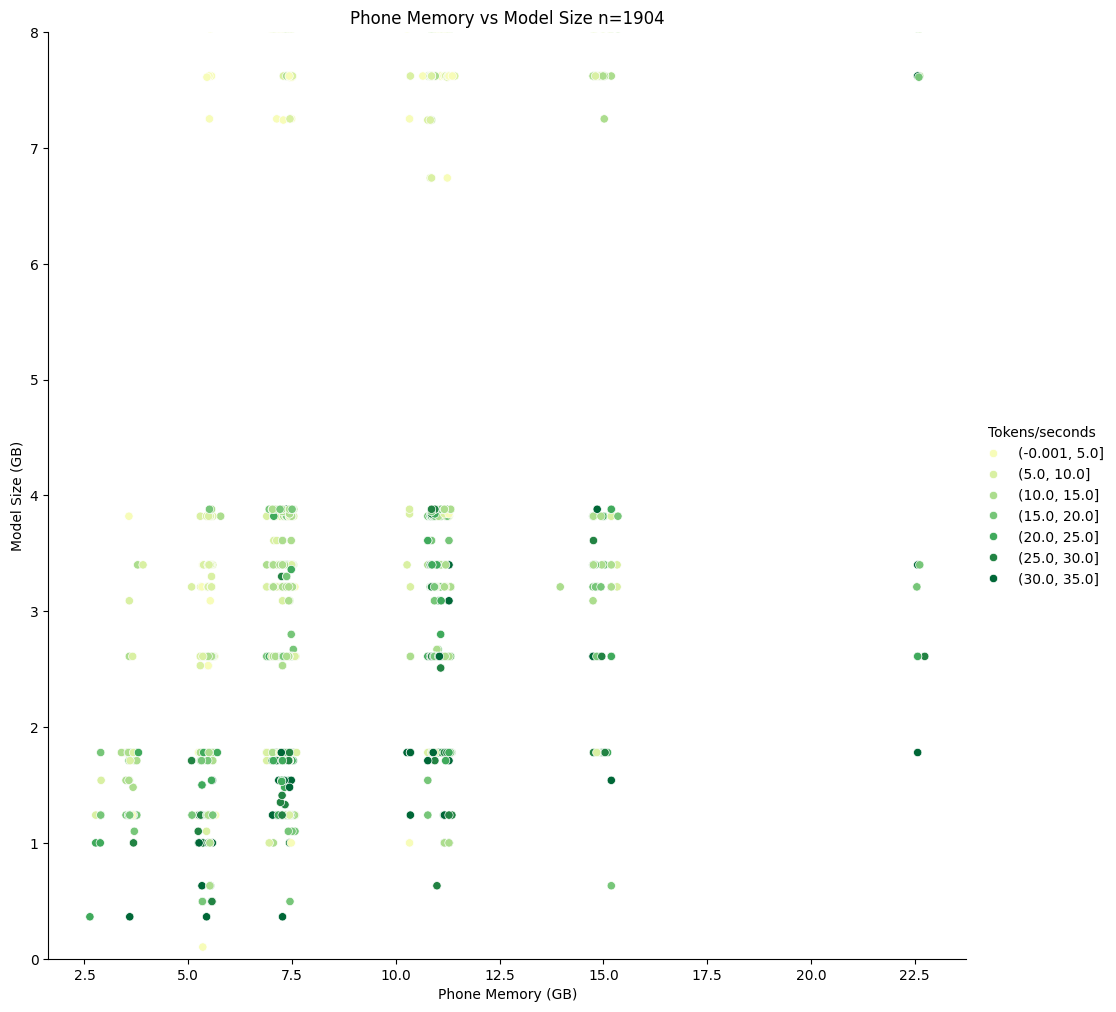

In [101]:
import seaborn as sns

bins = np.arange(0, 40, 5)  # Bins from 0 to 100 with step 10
data['PP Avg (t/s)_bins'] = pd.cut(data['PP Avg (t/s)'], bins=bins, include_lowest=True)

g = sns.FacetGrid(data, height=10, aspect=1)

# Map scatterplot with discretized hue
g.map_dataframe(sns.scatterplot, x="Total Memory (GB)", y="Model Size", hue="PP Avg (t/s)_bins", palette = "YlGn")

g.set(ylim=(0, 8))
g.add_legend(title="Tokens/seconds")

g.set_axis_labels("Phone Memory (GB)", "Model Size (GB)")
g.set_titles("Phone Memory vs Model Size")

plt.title(f"Phone Memory vs Model Size n={len(data)}")

plt.show()

In [102]:
data.head()

,Unnamed: 0,Device,Platform,CPU Cores,Total Memory (GB),PP Config,PP Avg (t/s),PP Std (t/s),TG Config,TG Avg (t/s),TG Std (t/s),Model ID,Model Size,n_threads,flash_attn,cache_type_k,cache_type_v,PP Avg (t/s)_bins
0,0,Xiaomi 11T,Android,8,7.33,512,28.41,NaN,128,9.73,NaN,Alcoft/granite-3.1-1b-a400m-instruct-GGUF/gran...,1.33,7,True,f16,f16,"(25.0, 30.0]"
1,1,Galaxy S24 Ultra,Android,8,10.83,512,35.84,NaN,128,8.73,NaN,ApexReign/DeepSeek-R1-Distill-Qwen-1.5B-Fully-...,1.78,8,True,f16,f16,NaN
2,2,Reno12 Pro 5G,Android,8,11.21,512,52.76,NaN,128,6.69,NaN,Bronsn/lama3.2-1B-translatev4/model-q8.gguf,1.24,6,False,f16,f16,NaN
3,3,iPhone 15 Pro,iOS,6,7.50,128,195.16,NaN,32,17.51,NaN,Dampfinchen/google-gemma-3-4b-it-qat-q4_0-gguf...,3.88,6,True,f16,f16,NaN
4,4,Galaxy S25 Ultra,Android,8,10.86,512,42.16,NaN,128,11.92,NaN,DavidAU/Gemma-3-it-4B-Uncensored-DBL-X-GGUF/Ge...,4.26,6,False,f16,f16,NaN


In [117]:
data_above_five = data[data["PP Avg (t/s)"] > 5]

In [247]:
data_above_seven = data[data["PP Avg (t/s)"] > 7]

In [113]:
data["rounded_model_size"] = data['Model Size'].round(0)


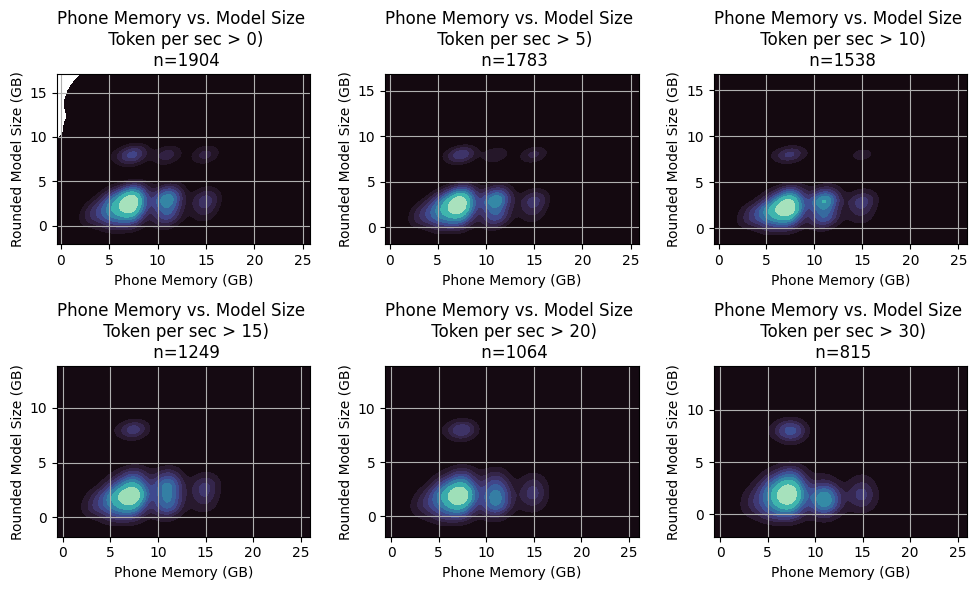

In [125]:
# prompt: Make lantern plots with rounded_model_size as y

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' DataFrame is already defined from the previous code

# Create subplots with correct syntax
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))

# Flatten the axes array for easier iteration
axes = axes.flatten()

for idx, tok in enumerate([0, 5, 10, 15, 20, 30]):
    data_filtered = data[data['PP Avg (t/s)'] >= tok]
    # Create the lantern plot
    sns.kdeplot(data=data_filtered, x='Total Memory (GB)', y='rounded_model_size', fill=True, cmap="mako", thresh=0, ax=axes[idx])
    axes[idx].set_xlabel("Phone Memory (GB)")
    axes[idx].set_ylabel("Rounded Model Size (GB)")
    axes[idx].set_title(f"Phone Memory vs. Model Size \n Token per sec > {tok})\n n={len(data_filtered)}")
    axes[idx].grid(True)

# Adjust layout to prevent overlapping
plt.tight_layout()
plt.show()

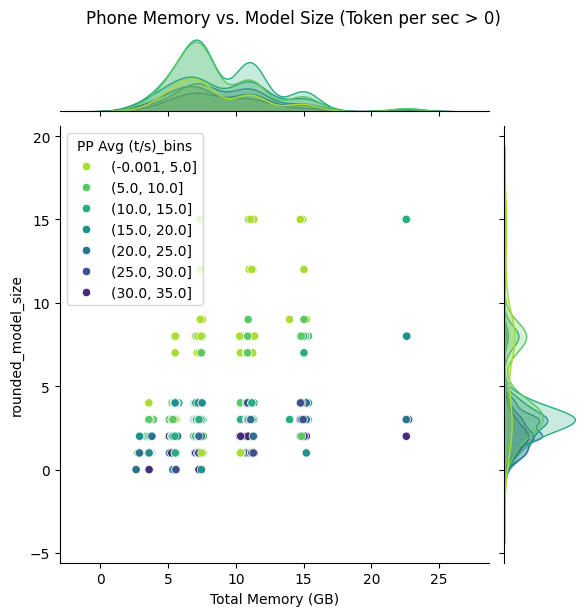

In [131]:
for tok in [0]:
         data_filtered = data[data['PP Avg (t/s)'] >= tok]
         sns.jointplot(data=data_filtered, x='Total Memory (GB)', y='rounded_model_size', kind='scatter', hue='PP Avg (t/s)_bins', palette='viridis_r')
         plt.suptitle(f"Phone Memory vs. Model Size (Token per sec > {tok})", y=1.02)  # Adjust title position
         plt.show()

In [105]:
reduced_data = data[["Model Size", "CPU Cores", "PP Config", "Total Memory (GB)", "PP Avg (t/s)"]]

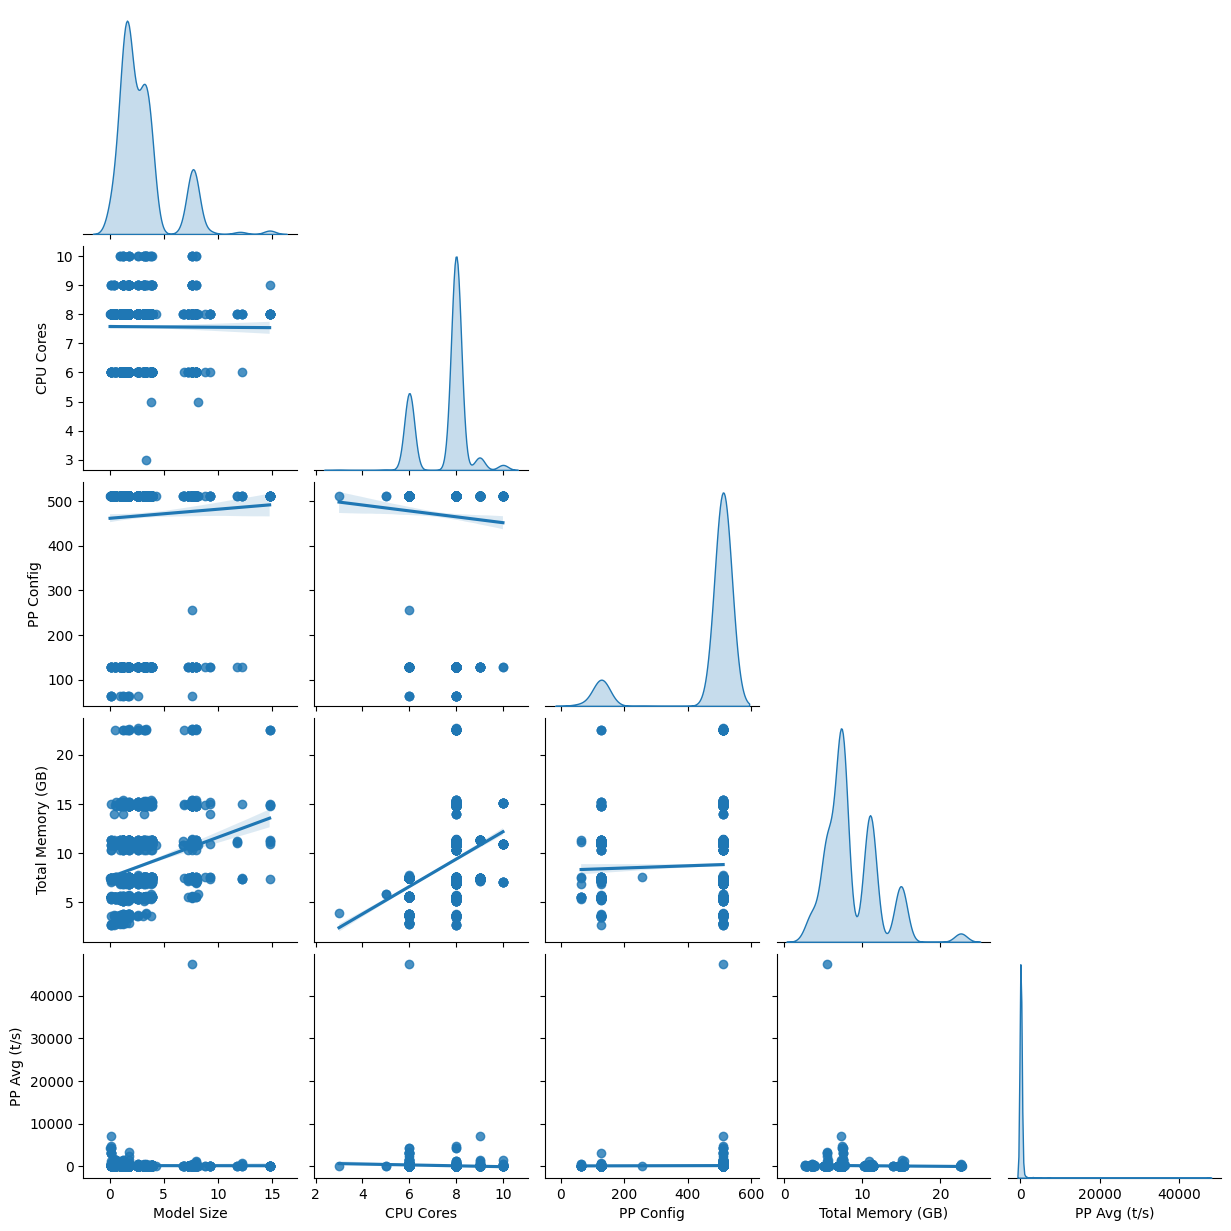

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

# data_aggregated = data.groupby("rounded_memory").agg({
#     'rounded_memory': 'count',
#     'Model Size': ['mean', 'std'],  # Added std for Model Size
#     'PP Avg (t/s)': ['mean', 'std']  # Added std for PP Avg (t/s)
# })

# Flatten MultiIndex columns for easier plotting

# Create the pairplot
sns.pairplot(reduced_data, kind='reg', corner=True, diag_kind='kde')

# Show the plot
plt.show()

In [133]:
data_aggregated

,Count,Model Size_mean,Model Size_std,PP Avg (t/s)_mean,PP Avg (t/s)_std
rounded_memory,,,,,
2.6,1,0.362000,NaN,24.230000,NaN
2.7,3,0.135000,0.000000,195.016667,126.010803
2.8,4,0.751250,0.481393,37.272500,26.312014
2.9,7,1.291429,0.282337,19.327143,6.526926
3.4,1,1.780000,NaN,14.990000,NaN
3.5,5,1.286000,0.431022,25.432000,20.500214
3.6,53,1.486434,0.612411,89.785975,123.409579
3.7,16,1.445125,0.506351,20.437812,16.835456
3.8,10,1.766000,0.624236,68.899500,97.220437


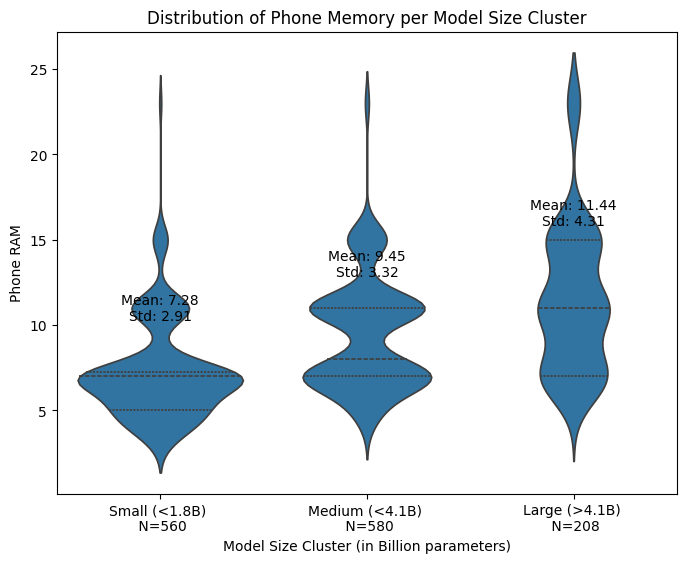

In [159]:
# prompt: cluster model size around 1, 3 or 7 (Small / Medium / Large), then make a violin plot with t/s avg and std for each cluster

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data' DataFrame is already defined and loaded

# Define model size clusters
def cluster_model_size(size):
  if size <= 1.8:
    return f'Small (<1.8B) \n N=560'
  elif size <= 4.1:
    return 'Medium (<4.1B) \n N=580'
  else:
    return 'Large (>4.1B) \n N=208'

data['model_size_cluster'] = data['Model Size'].apply(cluster_model_size)
data = data[data["PP Avg (t/s)"] < 50]
# Create the violin plot

# Calculate t/s statistics for each cluster
cluster_stats = data.groupby('model_size_cluster')['phone_memory'].agg(['mean', 'std'])

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='model_size_cluster', y='phone_memory', data=data, inner="quartile",
               order=['Small (<1.8B) \n N=560', 'Medium (<4.1B) \n N=580', 'Large (>4.1B) \n N=208'])  # Specify the order
plt.title('Distribution of Phone Memory per Model Size Cluster')
plt.xlabel('Model Size Cluster (in Billion parameters)')
plt.ylabel('Phone RAM')


# Add mean and standard deviation to the plot

# Annotate the plot with mean and standard deviation
for i, row in cluster_stats.iterrows():
    plt.text(i, row['mean'] + row['std'] + 0.1, f"Mean: {row['mean']:.2f}\nStd: {row['std']:.2f}", ha='center')

plt.show()


In [155]:
data['model_size_cluster'].value_counts()

,count
model_size_cluster,
Medium (<4.1B),580
Small (<1.8B),560
Large (>4.1B),208


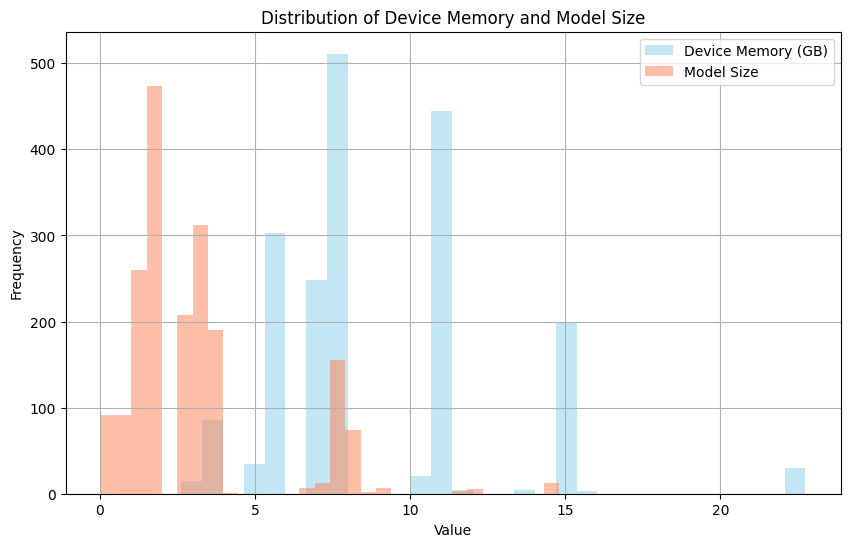

In [43]:
# prompt: Dear with skewed distribution

import matplotlib.pyplot as plt

# Assuming 'device_mem' and 'model_size' are already defined as in your previous code

plt.figure(figsize=(10, 6))
plt.hist(device_mem, bins=30, alpha=0.5, label='Device Memory (GB)', color='skyblue')
plt.hist(model_size, bins=30, alpha=0.5, label='Model Size', color='coral')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Device Memory and Model Size')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [33]:
(device_mem.to_numpy()).reshape(-1, 1)

(1904,)

In [30]:
model_size.shape

(1904,)

In [34]:
import numpy as np
reg = LinearRegression()
reg.fit((device_mem.to_numpy()).reshape(-1, 1), model_size.to_numpy())

LinearRegression()

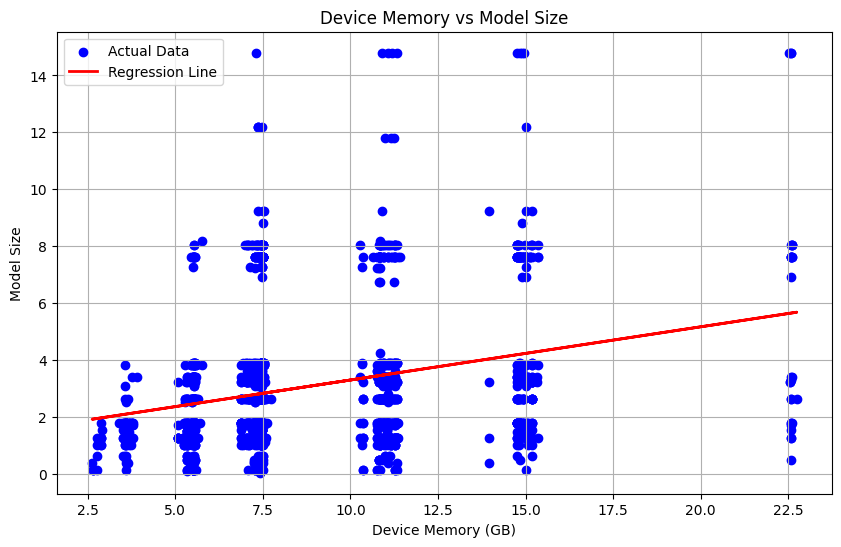

Intercept: 1.4221371839903962
Coefficient: [0.18709545]
Predicted model size for 19 GB device memory: 4.976950798439333


In [41]:
# prompt: It should be Device Memoty vs Model size

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Assuming your data is loaded into a pandas DataFrame called 'data'
# and it contains columns "Total Memory (GB)" and "Model Size"

# Extract the relevant columns
device_mem = data["Total Memory (GB)"]
model_size = data["Model Size"]

# Create the linear regression model
reg = LinearRegression()

# Reshape the device memory data for fitting
X = (device_mem.to_numpy()).reshape(-1, 1)
y = model_size.to_numpy()

# Fit the model
reg.fit(X, y)

# Predict model sizes based on device memory
y_pred = reg.predict(X)

# Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Actual Data')
plt.plot(X, y_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel('Device Memory (GB)')
plt.ylabel('Model Size')
plt.title('Device Memory vs Model Size')
plt.legend()
plt.grid(True)
plt.show()

# Print the model coefficients
print("Intercept:", reg.intercept_)
print("Coefficient:", reg.coef_)

# You can now use the model to predict the model size for a given device memory
# For example:
new_device_memory = 19  # GB
predicted_model_size = reg.predict(np.array([[new_device_memory]]))
print(f"Predicted model size for {new_device_memory} GB device memory: {predicted_model_size[0]}")


In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"

# Column names for the dataset (from UCI Covertype description)
columns = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
           'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
           'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
           'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6',
           'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13',
           'Soil_Type14', 'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
           'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27',
           'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
           'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', 'Cover_Type']

data = pd.read_csv(url, header=None)
data.columns=columns

In [ ]:
data.shape

(581012, 55)

Next, we'll separate out the classification variable (Cover_Type) from the rest of the data. This is what we will aim to predict with our classification model. We can also split our dataset into training and test data using the scikit-learn train_test_split function.

In [ ]:
X, y = data.drop('Cover_Type', axis=1), data['Cover_Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Now that we have our dataset split, we're ready to run a model. To start, we will just run the model using the sklearn library with a starting max depth of 5 and all of the features. Note that we can set n_jobs=-1 to utilize all available CPU cores for fitting the trees -- this will ensure we get the best performance possible on our system's CPU.  

In [ ]:
%%time

clf = RandomForestClassifier(n_estimators=100, max_depth=5, max_features=1.0, n_jobs=-1)
clf.fit(X_train, y_train)

CPU times: user 3min 57s, sys: 1.29 s, total: 3min 58s
Wall time: 2min 29s


RandomForestClassifier(max_depth=5, max_features=1.0, n_jobs=-1)

In about 2 minutes, we were able to fit our tree model using scikit-learn. This is not bad! Let's use the model we just trained to predict coverage types in our test dataset and take a look at the accuracy of our model.

In [ ]:
y_pred = clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.7043707993769524

We can also print out a full classification report to better understand how we predicted different Coverage_Type categories.

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.68      0.68      0.68     42446
           2       0.73      0.78      0.76     56686
           3       0.63      0.86      0.73      7172
           4       0.58      0.39      0.47       541
           5       0.94      0.01      0.02      1897
           6       0.72      0.03      0.06      3423
           7       0.72      0.48      0.58      4038

    accuracy                           0.70    116203
   macro avg       0.72      0.46      0.47    116203
weighted avg       0.71      0.70      0.69    116203



With scikit-learn, we built a model that was able to be trained in just a couple minutes. From the accuracy report, we can see that we predicted the correct class around 70% of the time, which is not bad but could certainly be improved.

Often we want to run several different random forest models in order to optimize our hyperparameters. For example, we may want to increase the number of estimators, or modify the maximum depth of our tree. When running dozens or hundreds of different hyperparameter combinations, things start to become quite slow and iteration takes a lot longer.

We provide some sample code utilizing GridSearchCV below to show what this process might look like. All of these combinations would take a LONG time to run if we spend 2 minutes fitting each model.

In [ ]:
"""
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
"""

Now let's load cuml.accel and try running the same code again to see what kind of acceleration we can get.

In [ ]:
%load_ext cuml.accel

[2025-03-10 20:51:44.205] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-03-10 20:51:55.508] [CUML] [info] cuML: Installed accelerator for umap.
[2025-03-10 20:51:55.521] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-03-10 20:51:55.521] [CUML] [info] cuML: Successfully initialized accelerator.


After loading the IPython magic, we need to import the sklearn estimators we wish to use again.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
%%time

clf = RandomForestClassifier(n_estimators=100, max_depth=5, max_features=1.0, n_jobs=-1)
clf.fit(X_train, y_train)

CPU times: user 3.48 s, sys: 2.3 s, total: 5.78 s
Wall time: 3.17 s


RandomForestClassifier(max_depth=5, max_features=1.0, n_jobs=-1)

That was much faster! Using cuML we're able to train this random forest model in just seconds instead of minutes. One thing to note is that cuML's implementation of RandomForestClassifier doesn't utilize the `n_jobs` parameter like scikit-learn, but we still accept it which makes it easier to use this accelerator with zero code changes.

Let's take a look at the same accuracy score and classification report to compare the model's performance.

In [ ]:
y_pred = clf.predict(X_test)
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           1       0.68      0.69      0.68     42446
           2       0.73      0.78      0.75     56686
           3       0.64      0.86      0.73      7172
           4       0.66      0.44      0.53       541
           5       0.53      0.05      0.09      1897
           6       0.73      0.03      0.06      3423
           7       0.73      0.48      0.58      4038

    accuracy                           0.70    116203
   macro avg       0.67      0.48      0.49    116203
weighted avg       0.70      0.70      0.69    116203



Out of the box, the model performed about the same as the scikit-learn implementation. Because this model ran so much faster, we can quickly iterate on the hyperparameter configuration and find a model that performs better with excellent speedups.

In [ ]:
%%time

clf = RandomForestClassifier(n_estimators=100, max_depth=30, max_features=1.0, n_jobs=-1)
clf.fit(X_train, y_train)

CPU times: user 17.2 s, sys: 12.4 s, total: 29.6 s
Wall time: 16.7 s


RandomForestClassifier(max_depth=30, max_features=1.0, n_jobs=-1)

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.97      0.96      0.96     42446
           2       0.97      0.98      0.97     56686
           3       0.96      0.96      0.96      7172
           4       0.90      0.89      0.89       541
           5       0.93      0.85      0.89      1897
           6       0.93      0.93      0.93      3423
           7       0.97      0.96      0.96      4038

    accuracy                           0.96    116203
   macro avg       0.95      0.93      0.94    116203
weighted avg       0.96      0.96      0.96    116203



With a model that runs in just seconds, we can perform hyperparameter optimization using a method like the grid search shown above, and have results in just minutes instead of hours.

# CPU Fallback



There are some algorithms and functionality from scikit-learn, UMAP, and HDBSCAN that are *not* implemented in cuML. For cases where the underlying functionality is not supported on GPU, the cuML accelerator will gracefully fall back and execute on the CPU instead.


In [ ]:
from sklearn.neighbors import KernelDensity
import numpy as np

X = np.concatenate((np.random.normal(0, 1, 10000),
                    np.random.normal(5, 1, 10000)))[:, np.newaxis]


In [ ]:
kde = KernelDensity(kernel='gaussian', bandwidth=0.5)
kde.fit(X)


KernelDensity(bandwidth=0.5)

In [ ]:
print(kde.score_samples(X))

[-1.73977133 -1.96377755 -1.85124204 ... -1.7259015  -1.87922778
 -1.9905058 ]


Next, let's restart the kernel to unload the accelerator extension and observe the same performance comparisons on a few other algorithms.

In [ ]:
get_ipython().kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

We'll now take a look at a clustering example using HDBSCAN.


# Clustering

Clustering is an important data science workflow because it helps uncover hidden patterns and structures within data without requiring labeled outcomes. In practice, with high dimensional data it can be difficult to discern whether the clusters we've chosen are good or not. One way to determine the quality of our clustering is with sklearn's [silhouette score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score), which we'll examine shortly.

HDBSCAN is a popular density-based clustering algorithm that is highly flexible. We'll load a toy sklearn dataset to illustrate how HDBSCAN can be accelerated with cuml.accel.

In [ ]:
import hdbscan
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score

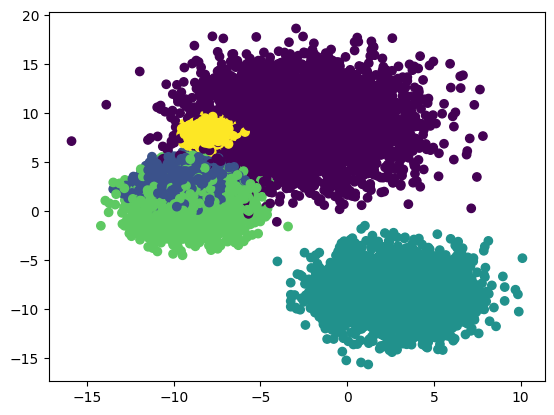

In [ ]:
N = 20000
K = 100

X, y = make_blobs(
    n_samples=N,
    n_features=K,
    centers=5,
    cluster_std=[3,1,2,1.5,0.5],
    random_state=42
)

plt.scatter(X[:, 0], X[:, 1], c=y)

In [ ]:
clusterer = hdbscan.HDBSCAN()
%time clusterer.fit(X)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CPU times: user 46.1 s, sys: 128 ms, total: 46.3 s
Wall time: 46.7 s


HDBSCAN()

In [ ]:
print(silhouette_score(X, clusterer.labels_))

0.7352694189002873


In [ ]:
%load_ext cuml.accel

[2025-03-10 20:36:10.574] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-03-10 20:36:21.844] [CUML] [info] cuML: Installed accelerator for umap.
[2025-03-10 20:36:21.845] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-03-10 20:36:21.845] [CUML] [info] cuML: Successfully initialized accelerator.


In [ ]:
import hdbscan

In [ ]:
clusterer = hdbscan.HDBSCAN()
%time clusterer.fit(X)


CPU times: user 632 ms, sys: 185 ms, total: 816 ms
Wall time: 1.03 s


HDBSCAN()

Here we go from around 45 seconds to 1 second to fit the clustering model! This is a massive speed-up we got just from loading the `cuml.accel` extension.

In [ ]:
print(silhouette_score(X, clusterer.labels_))


0.7226569165160748



It's important to note that on real-world datasets, the silhouette score produced by the GPU and CPU implementations of HDBSCAN will often have slight differences. The cuML implementation of HDBSCAN should provide equivalent results, but it is normal for the actual clusters to vary slightly when dealing with complex datasets.

Lastly, let's take a look at how we can use cuml's accelerator mode for a third popular machine learning task -- dimensionality reduction. We'll restart the kernel to unload the extension yet again.

Keep in mind that we don't normally need to restart the kernel when using `cuml.accel`, we just do it for the sake of showing the speed-ups in this demo. In practice, you'd just load the accelerator one time up front and be set.

In [ ]:
get_ipython().kernel.do_shutdown(restart=True)

{'status': 'ok', 'restart': True}

# Dimensionality Reduction

UMAP is a popular dimensionality reduction technique that is used for both data visualization and as preprocessing for downstream modeling due to its ability to balance preserving both local and global structure of high-dimensional data. To learn more about how it works, visit the [UMAP documentation](https://umap-learn.readthedocs.io/en/latest/).

To explore how cuML can accelerate UMAP, let's load in another dataset from UCI. We'll use the Human Activity Recognition (HAR) dataset, which was created from recordings of 30 subjects performing activities of daily living (ADL) while carrying a waist-mounted smartphone with embedded inertial sensors.

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip -O /tmp/HAR_data.zip

--2025-03-10 20:39:18--  https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘/tmp/HAR_data.zip’

/tmp/HAR_data.zip       [                 <=>]  58.17M  17.0MB/s    in 4.4s    

2025-03-10 20:39:24 (13.3 MB/s) - ‘/tmp/HAR_data.zip’ saved [60999314]



In [ ]:
!unzip /tmp/HAR_data.zip -d /tmp/HAR_data/

Archive:  /tmp/HAR_data.zip
replace /tmp/HAR_data/UCI HAR Dataset/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd

X_train = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset/train/X_train.txt", sep="\s+", header=None)
y_train = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset/train/y_train.txt", sep="\s+", header=None)
X_test = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset/test/X_test.txt", sep="\s+", header=None)
y_test = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset/test/y_test.txt", sep="\s+", header=None)
labels = pd.read_csv("/tmp/HAR_data/UCI HAR Dataset/activity_labels.txt", sep="\s+", header=None)

In [ ]:
X_train.shape

(7352, 561)

Let's take a look at the activity labels to better understand the data we're working with. We can see that the sensors have grouped activities into 6 different classes.

In [ ]:
labels

,0,1
0,1,WALKING
1,2,WALKING_UPSTAIRS
2,3,WALKING_DOWNSTAIRS
3,4,SITTING
4,5,STANDING
5,6,LAYING


In [ ]:
from sklearn.preprocessing import StandardScaler

# Scale the data before applying UMAP
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)


Let's run UMAP with some basic parameters and explore a lower-dimensionality projection of this dataset.

In [ ]:
import umap
umap_model = umap.UMAP(n_neighbors=15, n_components=2, random_state=42, min_dist=0.0)

In [ ]:
%%time

# Fit UMAP model to the data
X_train_umap = umap_model.fit_transform(X_train_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


CPU times: user 36.6 s, sys: 1.09 s, total: 37.6 s
Wall time: 52.2 s


It's often quite interesting to visualize the resulting projection of the embeddings created by UMAP. In this case, let's take a look at the now 2-dimensional dataset.

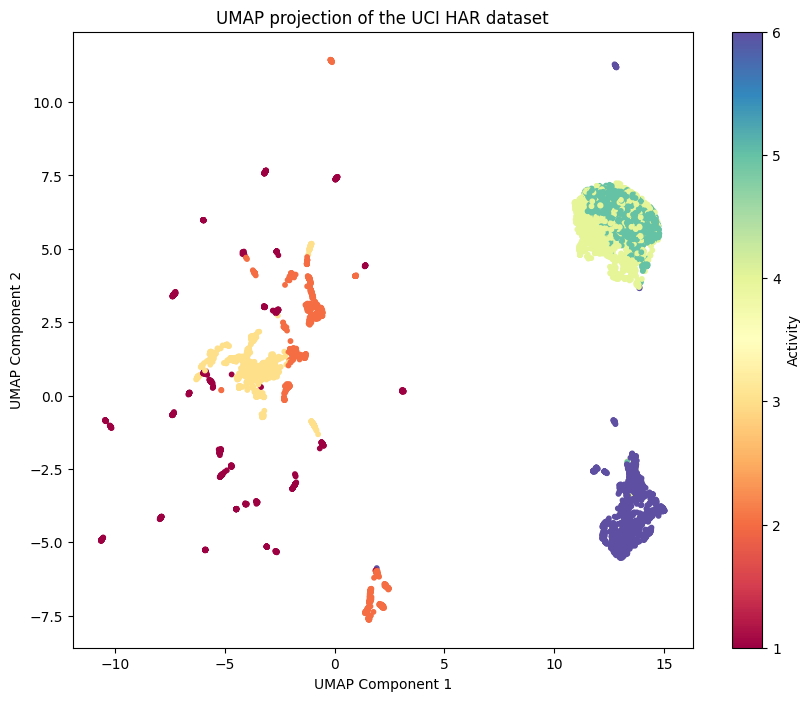

In [ ]:
import matplotlib.pyplot as plt

# Plot the UMAP result
plt.figure(figsize=(10, 8))
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train.values.ravel(), cmap='Spectral', s=10)
plt.colorbar(label="Activity")
plt.title("UMAP projection of the UCI HAR dataset")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()


It's interesting to see how our different categories are grouped in relation to one another.

We can look at the trustworthiness score to better understand how well the structure of the original dataset was preserved by our 2D projection

In [ ]:
from sklearn.manifold import trustworthiness
trustworthiness(X_train, X_train_umap, n_neighbors=15)


0.9725294692634925

It looks like this projection is a great representation of our full dataset.

Let's now run the same thing with the accelerator turned on.

In [ ]:
%load_ext cuml.accel

[2025-03-10 20:42:01.171] [CUML] [info] cuML: Installed accelerator for sklearn.
[2025-03-10 20:42:01.172] [CUML] [info] cuML: Installed accelerator for umap.
[2025-03-10 20:42:01.183] [CUML] [info] cuML: Installed accelerator for hdbscan.
[2025-03-10 20:42:01.183] [CUML] [info] cuML: Successfully initialized accelerator.


In [ ]:
import umap
umap_model = umap.UMAP(n_neighbors=15, n_components=2, random_state=42, min_dist=0.0)

[2025-03-10 20:42:01.192] [CUML] [info] build_algo set to brute_force_knn because random_state is given


In [ ]:
%%time

# Fit UMAP model to the data
X_train_umap = umap_model.fit_transform(X_train_scaled)

CPU times: user 372 ms, sys: 152 ms, total: 523 ms
Wall time: 520 ms


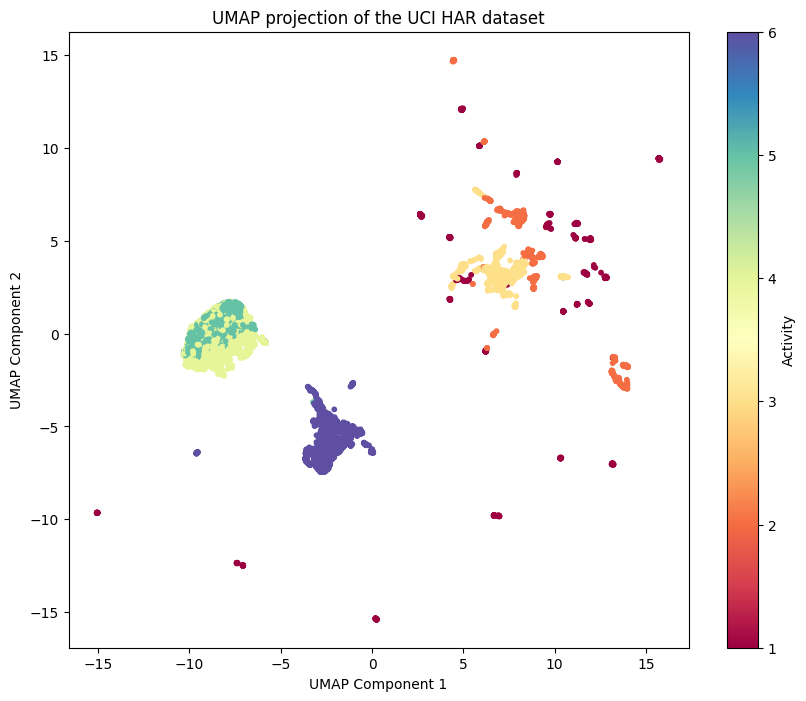

In [ ]:
import matplotlib.pyplot as plt

# Plot the UMAP result
plt.figure(figsize=(10, 8))
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train.values.ravel(), cmap='Spectral', s=10)
plt.colorbar(label="Activity")
plt.title("UMAP projection of the UCI HAR dataset")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()


Note that while the projection here is not identical to the umap-learn plot, the quality of the results are equivalent. We can run the trustworthiness score again to compare and verify this claim.

In [ ]:
from sklearn.manifold import trustworthiness
trustworthiness(X_train, X_train_umap, n_neighbors=15)


0.9709069888612091

For more information on getting started with `cuml.accel`, check out [RAPIDS.ai](https://rapids.ai/cuml-accel/) or the [cuML Docs](https://docs.rapids.ai/api/cuml/stable/).